# Model randomly placed sensors on $\cos$ surface


In [1]:
from __future__ import print_function
from imp import reload

import numpy as np
import scipy
import time, datetime, warnings, os, sys

from scipy.optimize import root
from scipy.integrate import quad, dblquad
from scipy.special import erf, erfc, erfcx

import matplotlib.pyplot as plt
% matplotlib inline

# Custom files
sys.path.insert(0, '../simulation')
from imp import reload
# Style
import style as style; reload(style)
colors = style.colors

In [27]:
### Sample points
# Number of points
n = 1000
# Radius of circle
R_orig = 0.3
# Length scale
L_orig = 1.
R = 2 * np.pi * R_orig / L_orig
# Radii
r_i = 2 * np.random.uniform(size=n) / R**2
# Angles
a_i = np.random.uniform(size=n) * 2 * np.pi

# Total output
def f(a_vec, r_vec, a0, phi):
    return np.sum(np.cos(r_vec * np.cos(a0 - a_vec) + phi))
# Alternative form
def f2(a_vec, r_vec, a0, phi):
    theta_vec   = r_vec * np.cos(a0 - a_vec)
    a_tot       = np.sqrt(np.sum(np.cos(theta_vec[:, np.newaxis] - theta_vec[np.newaxis, :])))
    theta_tot   = np.arctan(np.sum(np.sin(theta_vec)) / np.sum(np.cos(theta_vec)))
    return a_tot * np.cos(phi + theta_tot)
def a_tot(a_vec, r_vec, a0):
    theta_vec   = r_vec * np.cos(a0 - a_vec)
    return np.sqrt(np.sum(np.cos(theta_vec[:, np.newaxis] - theta_vec[np.newaxis, :])))

# a0 = 0.2
# phi = np.linspace(0, np.pi, 100)
# fs, f2s = np.zeros((2, 100))
# for i in range(100):
#     fs[i] = f(a_i, r_i, a0, phi[i])
#     f2s[i] = f2(a_i, r_i, a0, phi[i])
    
# max(fs), max(f2s), a_tot(a_i, r_i, a0)


In [16]:
### Inverse CDF
def phi_z(z, order_par=8):
    """ Lagrange inverse up to order 2 * order_par - 1. Maximum order implemented: 15 ~ order_par = 8"""
    from scipy.misc import factorial
    gs = np.array([    1. /    2., 
                       1. /   16.,
                       1. /   16., 
                      43. /  256., 
                     223. /  256., 
                   60623. / 8192.,
                  764783. / 8192.,
                107351407. / 65536.,
                  ])[:order_par]
    exponents   = 2 * np.arange(order_par) + 1
    factorials  = factorial(exponents)
    factor_n    = gs / factorials
    if type(z) in (float, int):
        return np.sum(factor_n * z**exponents)
    else:
        return np.sum(factor_n[:, np.newaxis] * z[np.newaxis, :]**exponents[:, np.newaxis], axis=0)

def theta_u(u, Rp=np.pi):
    z = np.pi * (2 * u - 1)
    return Rp * np.sin(0.5 * phi_z(z))

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


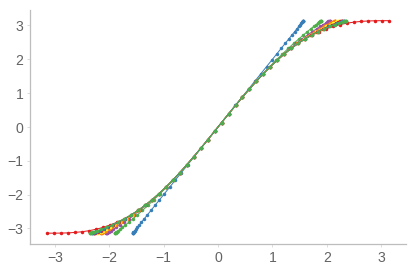

In [6]:
### Check inverse
phis = np.linspace(-np.pi, np.pi, 50)
zs = np.sin(phis) + phis

### Plot
fig = plt.figure(figsize=(6, 4))
ax0 = style.add_subplot(fig)
ax0.plot(phis, zs, ".-")
for i in range(8):
    phis_rec = phi_z(zs, order_par=i+1)
    ax0.plot(phis_rec, zs, ".-")
style.fixticks(fig)
plt.show(fig)
plt.close(fig)


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


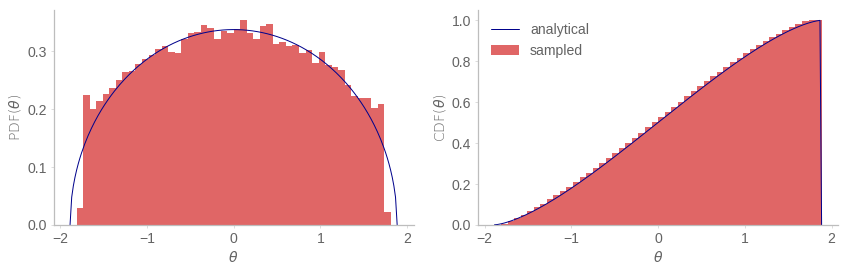

In [7]:
# Radius of circle
R = 0.3
# Length scale
L = 1.
Rp = 2 * np.pi * R / L

### Sample reduced angles directly
n_sample = 50000
u_i = np.random.uniform(size=n_sample)
theta_i = theta_u(u_i, Rp=Rp)

theta_plt = np.linspace(-Rp, Rp, 200)
def pdf_theta(theta):
    mask = (-Rp < theta) * (theta < Rp)
    return 2. / (np.pi * Rp) * np.sqrt(1 - (theta / Rp)**2) * mask
def cdf_theta(theta):
    mask = (-Rp < theta) * (theta < Rp)
    return (theta / Rp * np.sqrt(1 - (theta / Rp)**2) / np.pi + np.arcsin(theta / Rp) / np.pi + 0.5) * mask
pdf_plt = pdf_theta(theta_plt)
cdf_plt = cdf_theta(theta_plt)
# Bins for histogram
n_bins = 50
bins = np.linspace(-Rp, Rp, n_bins + 1)
dbin = 2 * Rp / n_bins

### Plot
fig = plt.figure(figsize=(12, 4))
ax0 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0))
ax1 = style.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1))
ax0.plot(theta_plt, pdf_plt, c=colors[0])
hist, _, _ = ax0.hist(theta_i, bins=bins, normed=True, color=colors[1], alpha=0.6)
ax1.plot(theta_plt, cdf_plt, c=colors[0], label="analytical")
hist, _, _ = ax1.hist(theta_i, bins=bins, normed=True, cumulative=True, 
                      color=colors[1], alpha=0.6, label="sampled")
ax1.legend(loc='best')
ax0.set_xlabel(r"$\theta$")
ax0.set_ylabel(r"$\mathrm{PDF}(\theta)$")
ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel(r"$\mathrm{CDF}(\theta)$")
style.fixticks(fig)
plt.show(fig)
plt.close(fig)

In [128]:
###### Number of instances
n_inst  = 10000
# Number of sensors
# n_sens_all = np.array([10, 50, 100, 200, 300])
# n_sens_all = np.array([5, 10, 20, 50, 100])
# m = len(n_sens_all)
n_sens = 20
# Portion of excitatory sensors
# f_E = 0.8
f_E = 0.5
# Balanced
g   = f_E / (1 - f_E)

# Radius of circle
R_all = np.linspace(0.01, 0.7, 20)
# Length scale
L = 1.
Rp_all = 2 * np.pi * R_all / L
m = len(R_all)

# Results
a_all = np.zeros((m, n_inst))
# for i, n_sens in enumerate(n_sens_all):
for i, Rp in enumerate(Rp_all):
    # Sample random numbers
    u_i = np.random.uniform(size=n_sens * n_inst)
    # Transform to theta
    theta_i = theta_u(u_i, Rp=Rp).reshape((n_sens, n_inst))
    # Calculate max output vector
    N_E = int(n_sens * f_E)
    N_I = n_sens - N_E
    ids = np.concatenate((np.ones(N_E), -g * np.ones(N_I)))
    ids_sq = ids[:, np.newaxis] * ids[np.newaxis, :]
    a_sq = (ids_sq[:, :, np.newaxis] * np.cos(theta_i[:, np.newaxis, :] - theta_i[np.newaxis, :, :])).sum(axis=(0, 1))
    # Save results
    a_all[i] = np.sqrt(a_sq)


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


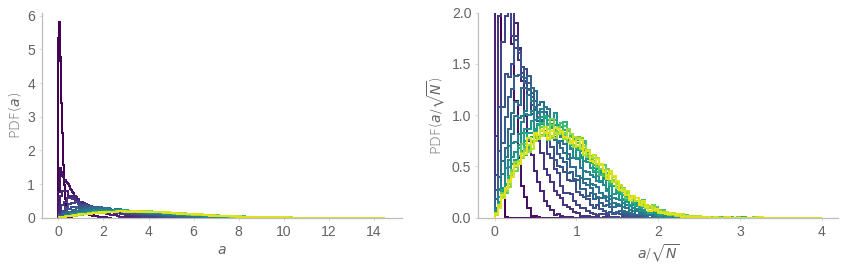

In [129]:
### Plot
fig = plt.figure(figsize=(12, 4))
n_cols = 2
for i in range(n_cols):
    style.add_subplot(fig, n_rows_cols=(1, n_cols), index_row_col=(0, i))
ax0, ax1 = fig.axes

# Bins for a / sqrt(N)
# aN_max  = np.ceil(np.max(a_all / np.sqrt(n_sens_all[:, np.newaxis])))
aN_max  = np.ceil(np.max(a_all / np.sqrt(n_sens)))
n_bins  = 100
bins    = np.linspace(0, aN_max, n_bins+1)

### Color lines continuously
import matplotlib.colors as mplcolors
import matplotlib.cm as cmx
cm          = plt.get_cmap('viridis') 
cNorm       = mplcolors.Normalize(vmin=0, vmax=m)
scalarMap   = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
# Draw histograms
for i, a in enumerate(a_all):
#     n = n_sens_all[i]
    
    R = R_all[i]
    # Continuos color
    c = scalarMap.to_rgba(i)
    ax0.hist(a,         bins=50,   normed=True, 
#              color=colors[i], linewidth=2., histtype="step", label=r"%d"%n_sens)
             color=c, linewidth=2, histtype="step", label=r"%.2f"%R)
    ax1.hist(a / np.sqrt(n_sens),     bins=bins, normed=True, 
#              color=colors[i], linewidth=2, histtype="step", label=r"%d"%n_sens)
             color=c, linewidth=2, histtype="step", label=r"%.2f"%R)
#     ax2.hist(a / n_sens,  bins=50, normed=True, color=colors[i], histtype="step", label=r"%d"%n_sens)
# ax0.legend(loc='best', title="N")
ax1.set_ylim(0, 2)
ax0.set_xlabel(r"$a$")
ax0.set_ylabel(r"$\mathrm{PDF}(a)$")
ax1.set_xlabel(r"$a / \sqrt{N}$")
ax1.set_ylabel(r"$\mathrm{PDF}(a / \sqrt{N})$")
# ax2.set_xlabel(r"$a / N$")
# ax2.set_ylabel(r"$\mathrm{PDF}(a / N)$")
style.fixticks(fig)
plt.show(fig)
plt.close(fig)

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


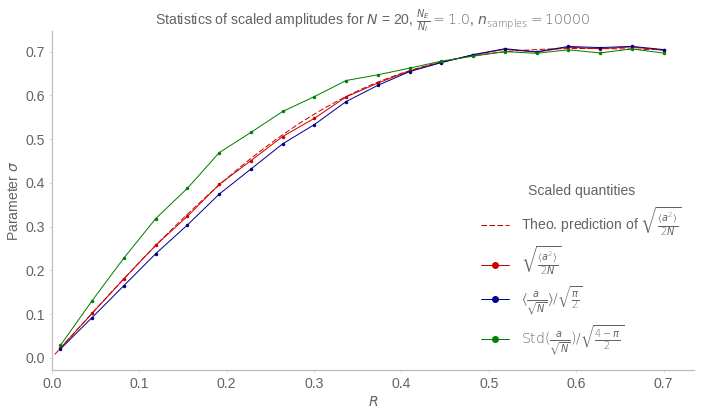

In [131]:
### Plot mean values
an = a_all / np.sqrt(n_sens)
an_means = an.mean(axis=1)
an_stds = an.std(axis=1)
an_meds = np.sort(an, axis=1)[:, int(n_inst / 2)]
an_skew = scipy.stats.skew(an, axis=1)
an_kurt = scipy.stats.kurtosis(an, axis=1)
# an_modes = np.zeros((m))
# for i, an_i in enumerate(an):
#     hist, _ = np.histogram(an_i, bins=bins)
#     an_modes[i] = bins[hist.argmax()]
an_sq_m = (an**2).mean(axis=1)

# Theoretical values for Rayleigh distribution
mean_r = np.sqrt(np.pi * 0.5)
std_r  = np.sqrt((4 - np.pi) * 0.5)
median_r = np.sqrt(2 * np.log(2))
skew_r = 2 * np.sqrt(np.pi) * (np.pi - 3) / (4 - np.pi)**(3. / 2.)
kurt_r = - (6 * np.pi**2 - 24 * np.pi + 16) / (4 - np.pi)**2

# Theoretical sigma for given R
R_plt = np.linspace(0, R_all.max(), 200)
from scipy.special import jv
def sigma_theo(R, f_E=0.5):
    Rp = 2 * np.pi * R / L
    b = np.sqrt(f_E * (1 + f_E / (1 - f_E)))
    return b * np.sqrt(0.5 - 2 / Rp**2 * jv(1, Rp)**2)

fig = plt.figure(figsize=(10, 6))
n_cols = 1
for i in range(n_cols):
    style.add_subplot(fig, n_rows_cols=(1, n_cols), index_row_col=(0, i))
# ax0, ax1 = fig.axes
ax0, = fig.axes

ax0.plot(R_plt, sigma_theo(R_plt, f_E=f_E), '--', c=colors[1], 
#          label="Theoretical prediction")
         label=r"Theo. prediction of $\sqrt{\frac{\langle a^2\rangle}{2N}}$")
ax0.plot(R_all, np.sqrt(an_sq_m / 2), '.-', c=colors[1], 
         label=r"$\sqrt{\frac{\langle a^2\rangle}{2N}}$")
ax0.plot(R_all, an_means / mean_r, '.-', c=colors[0], 
#          label="mean")
         label=r"$\langle \frac{a}{\sqrt{N}}\rangle / \sqrt{\frac{\pi}{2}}$")
ax0.plot(R_all, an_stds / std_r, '.-', c=colors[2], 
#          label="std dev")
         label=r"$\mathrm{Std}(\frac{a}{\sqrt{N}}) / \sqrt{\frac{4 - \pi}{2}}$")
# ax0.plot(R_all, an_meds / median_r, '.-', c=colors[2], label="median")

# ax0.plot(R_all, an_means, '.-', c=colors[0], label="Mean")
# ax0.plot(R_all, an_stds, '.-', c=colors[1], label="Std")
# ax0.plot(R_all, an_meds, '.-', c=colors[2], label="Median")
# ax0.plot(R_all, an_modes, '.-', c=colors[3], label="Mode")

# ax1.plot(R_all, an_skew / skew_r, '.-', c=colors[0], label="Skewness")
# ax1.plot(R_all, an_kurt / kurt_r, '.-', c=colors[1], label="Ex. kurtosis")
# ax1.plot(R_all, an_means / an_stds, '.-', c=colors[0], label="Mean / Std")
# ax1.plot(R_all, an_means / an_meds, '.-', c=colors[2], label="Mean / Median")
# ax1.plot(R_all, an_means / an_stds**2, '.-', c=colors[1], label="Mean / Var")

ax0.set_title(r"Statistics of scaled amplitudes for $N$ = %d, $\frac{N_E}{N_I} = %.1f$, $n_\mathrm{samples} = %d$"%(n_sens, N_E / N_I, n_inst))
ax0.legend(loc='best', title="Scaled quantities")
ax0.set_xlim(0, None)
ax0.set_xlabel(r"$R$")
ax0.set_ylabel(r"Parameter $\sigma$")
# ax1.legend(loc='best')
# ax1.set_ylim(0, 5)
# ax1.set_xlabel(r"$R$")
style.fixticks(fig)
plt.show(fig)
plt.close(fig)

In [114]:
###### Number of instances
n_inst  = 10000
# Number of sensors
# n_sens_all = np.array([10, 50, 100, 200, 300])
n_sens_all = np.array([5, 10, 20, 50, 100])
m = len(n_sens_all)
# n_sens = 20
# Portion of excitatory sensors
# f_E = 0.8
f_E = 0.5
# Balanced
g   = f_E / (1 - f_E)

# Radius of circle
# R_all = np.linspace(0.01, 0.7, 20)
R = 0.5
# Length scale
L = 1.
Rp = 2 * np.pi * R / L
# Rp_all = 2 * np.pi * R_all / L
# m = len(R_all)

# Results
a_all = np.zeros((m, n_inst))
for i, n_sens in enumerate(n_sens_all):
# for i, Rp in enumerate(Rp_all):
    # Sample random numbers
    u_i = np.random.uniform(size=n_sens * n_inst)
    # Transform to theta
    theta_i = theta_u(u_i, Rp=Rp).reshape((n_sens, n_inst))
    # Calculate max output vector
    N_E = int(n_sens * f_E)
    N_I = n_sens - N_E
    ids = np.concatenate((np.ones(N_E), -g * np.ones(N_I)))
    ids_sq = ids[:, np.newaxis] * ids[np.newaxis, :]
    a_sq = (ids_sq[:, :, np.newaxis] * np.cos(theta_i[:, np.newaxis, :] - theta_i[np.newaxis, :, :])).sum(axis=(0, 1))
    # Save results
    a_all[i] = np.sqrt(a_sq)


/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


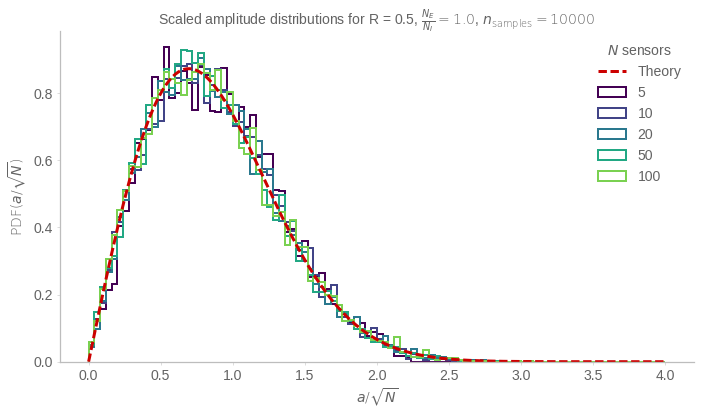

In [115]:
## Plot
fig = plt.figure(figsize=(10, 6))
n_cols = 1
for i in range(n_cols):
    style.add_subplot(fig, n_rows_cols=(1, n_cols), index_row_col=(0, i))
ax0, = fig.axes

# Bins for a / sqrt(N)
an_max  = np.ceil(np.max(a_all / np.sqrt(n_sens_all[:, np.newaxis])))
n_bins  = 100
bins    = np.linspace(0, an_max, n_bins+1)

# Theoretical distribution
def Rayleigh_dist(x, sigma):
    return x / sigma**2 * np.exp(-x**2 / (2 * sigma**2))
an_plt = np.linspace(0, an_max, 200)
sigma = sigma_theo(R, f_E=f_E)
dist_theo = Rayleigh_dist(an_plt, sigma)

### Color lines continuously
import matplotlib.colors as mplcolors
import matplotlib.cm as cmx
cm          = plt.get_cmap('viridis') 
cNorm       = mplcolors.Normalize(vmin=0, vmax=m)
scalarMap   = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
# Draw histograms
for i, a in enumerate(a_all):
    n_sens = n_sens_all[i]
    
    # Continuos color
    c = scalarMap.to_rgba(i)
    ax0.hist(a / np.sqrt(n_sens),     bins=bins, normed=True, 
             color=c, linewidth=2, histtype="step", label=r"%d"%n_sens)
#              color=c, linewidth=2, histtype="step", label=r"%.2f"%R)
# Theory
ax0.plot(an_plt, dist_theo, "--", c=colors[1], linewidth=3, label="Theory")

ax0.set_title(r"Scaled amplitude distributions for R = %.1f, $\frac{N_E}{N_I} = %.1f$, $n_\mathrm{samples} = %d$"%(R, N_E / N_I, n_inst))
ax0.legend(loc='best', title="$N$ sensors")
ax0.set_xlabel(r"$a / \sqrt{N}$")
ax0.set_ylabel(r"$\mathrm{PDF}(a / \sqrt{N})$")
style.fixticks(fig)
plt.show(fig)
plt.close(fig)

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


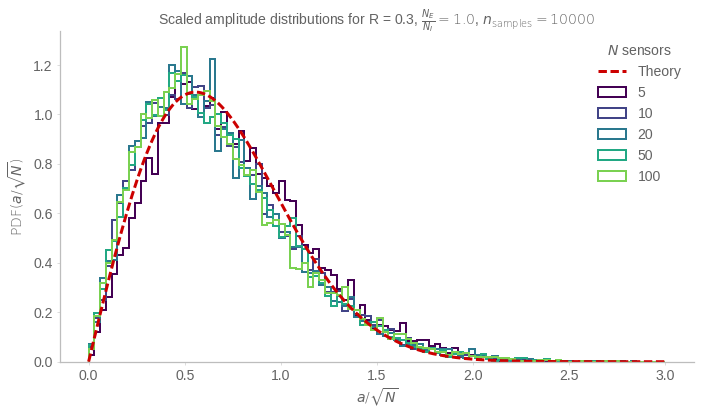

/home/fs/Code/env/lib/python3.4/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


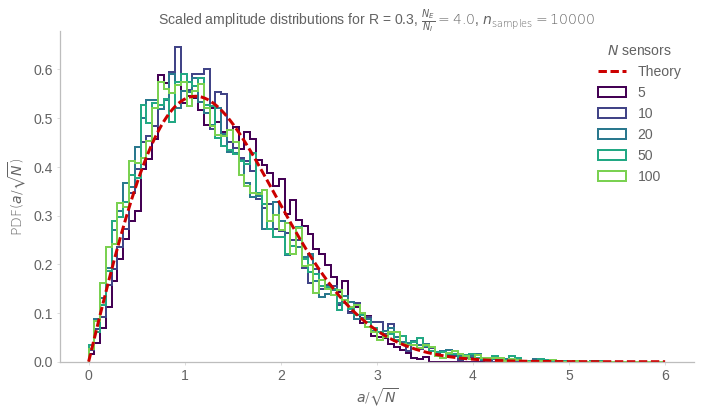